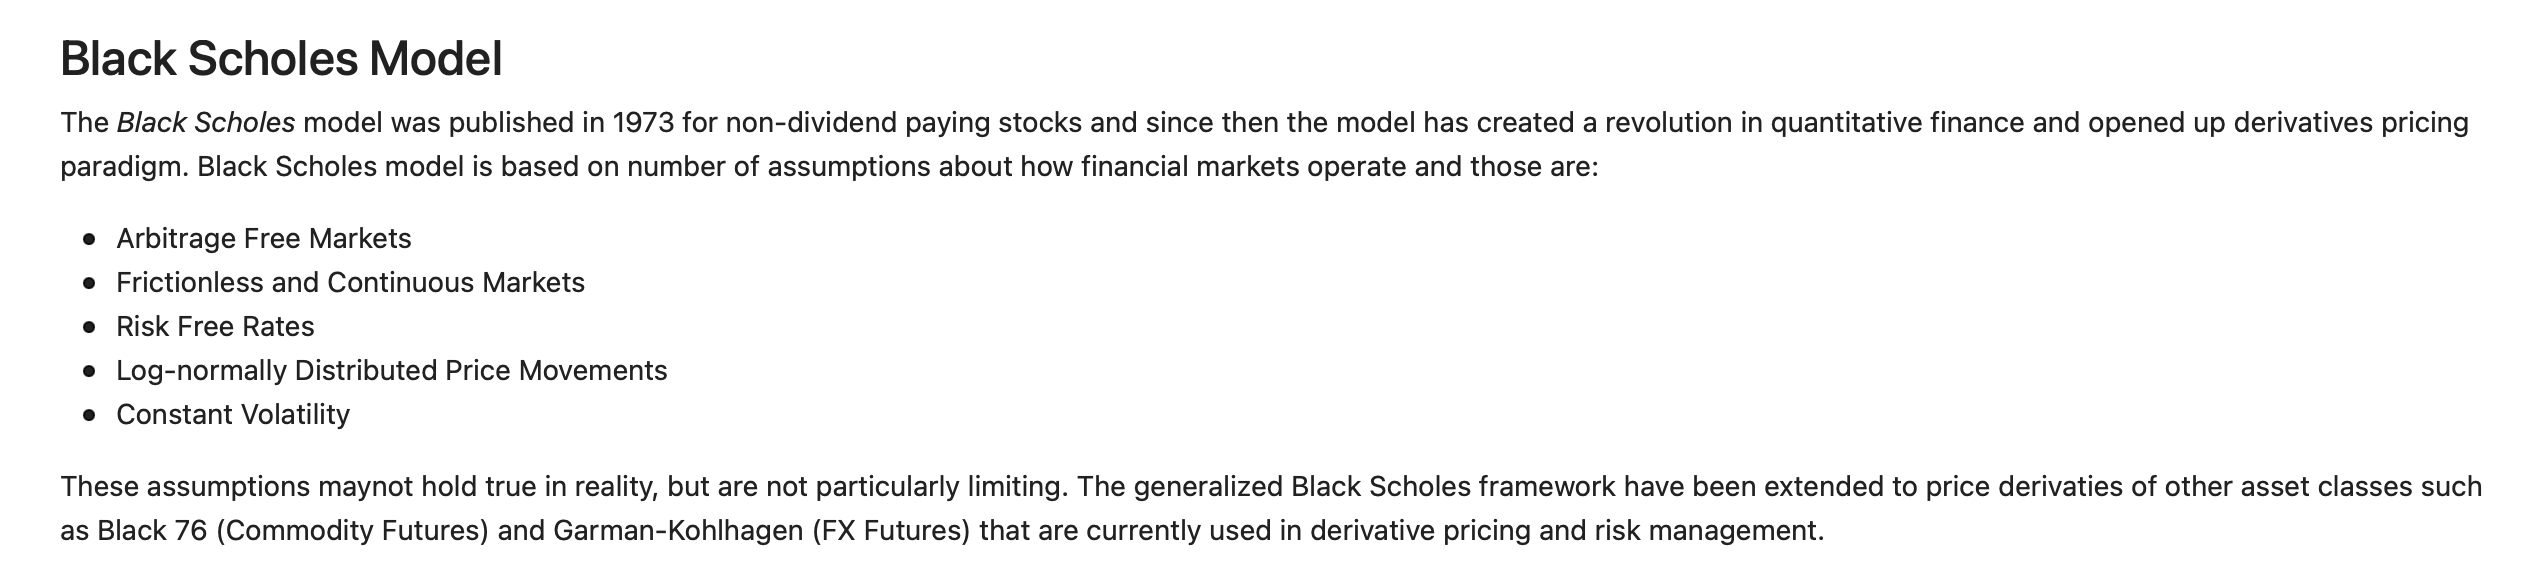

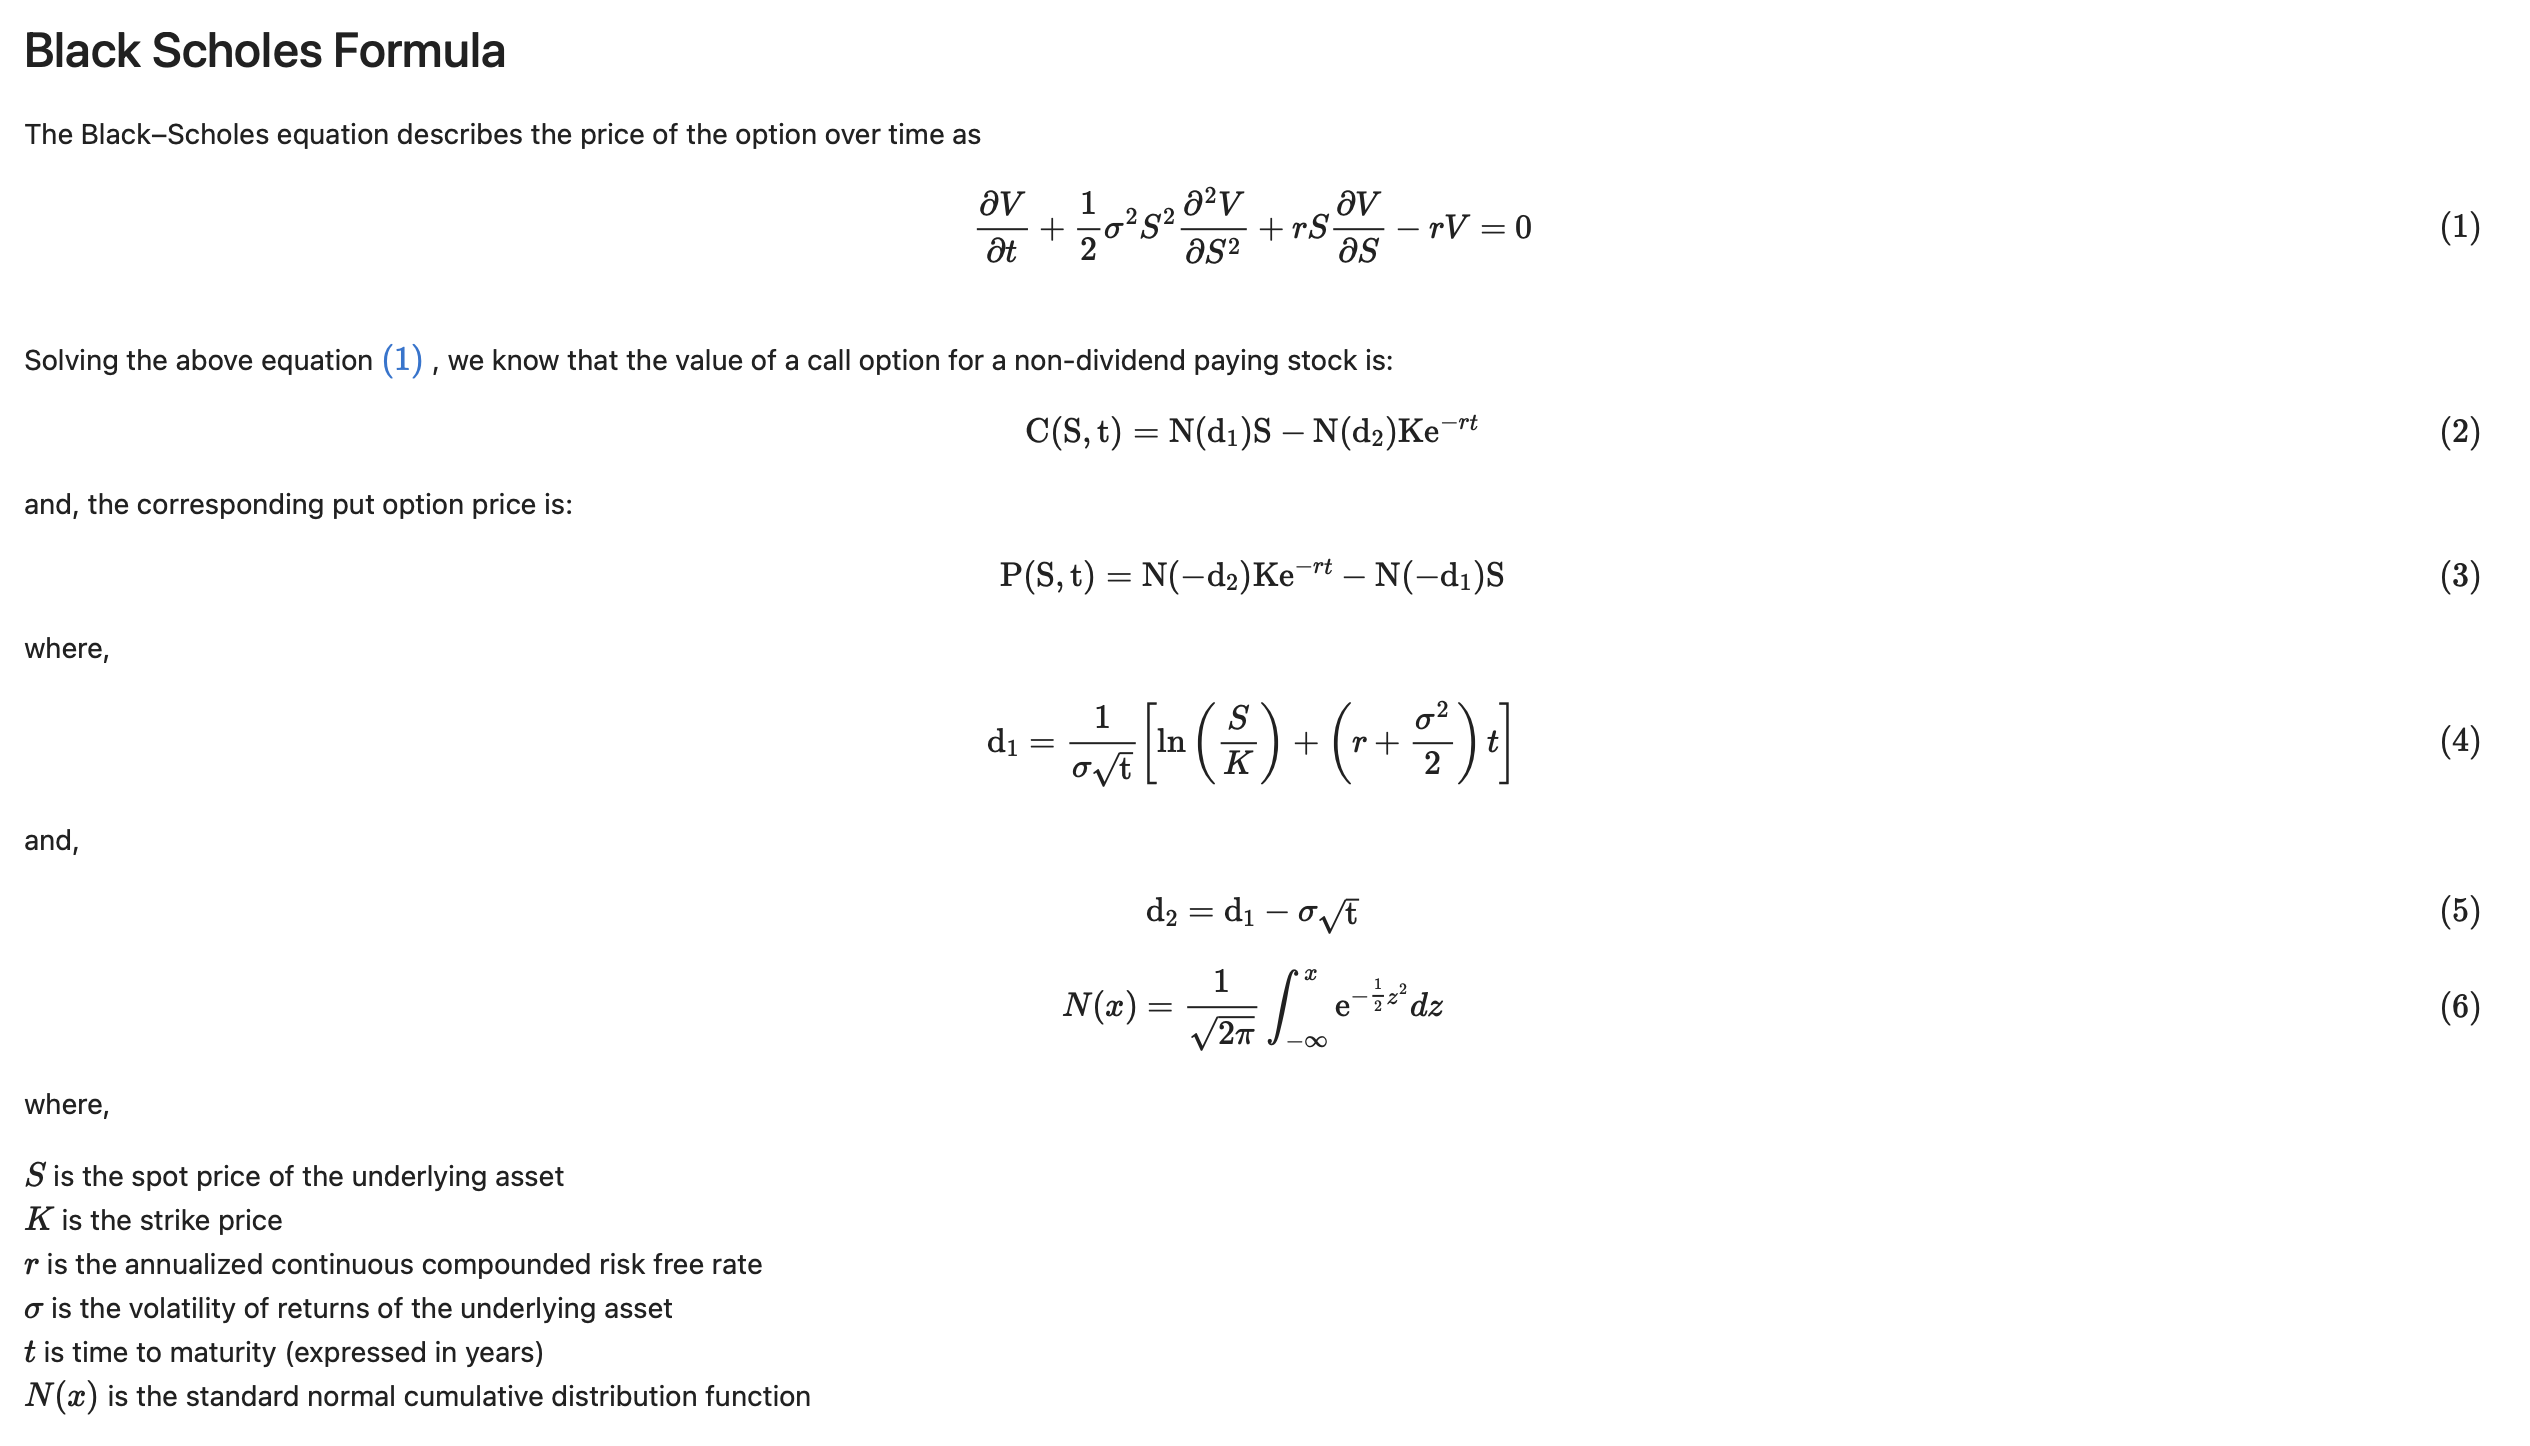

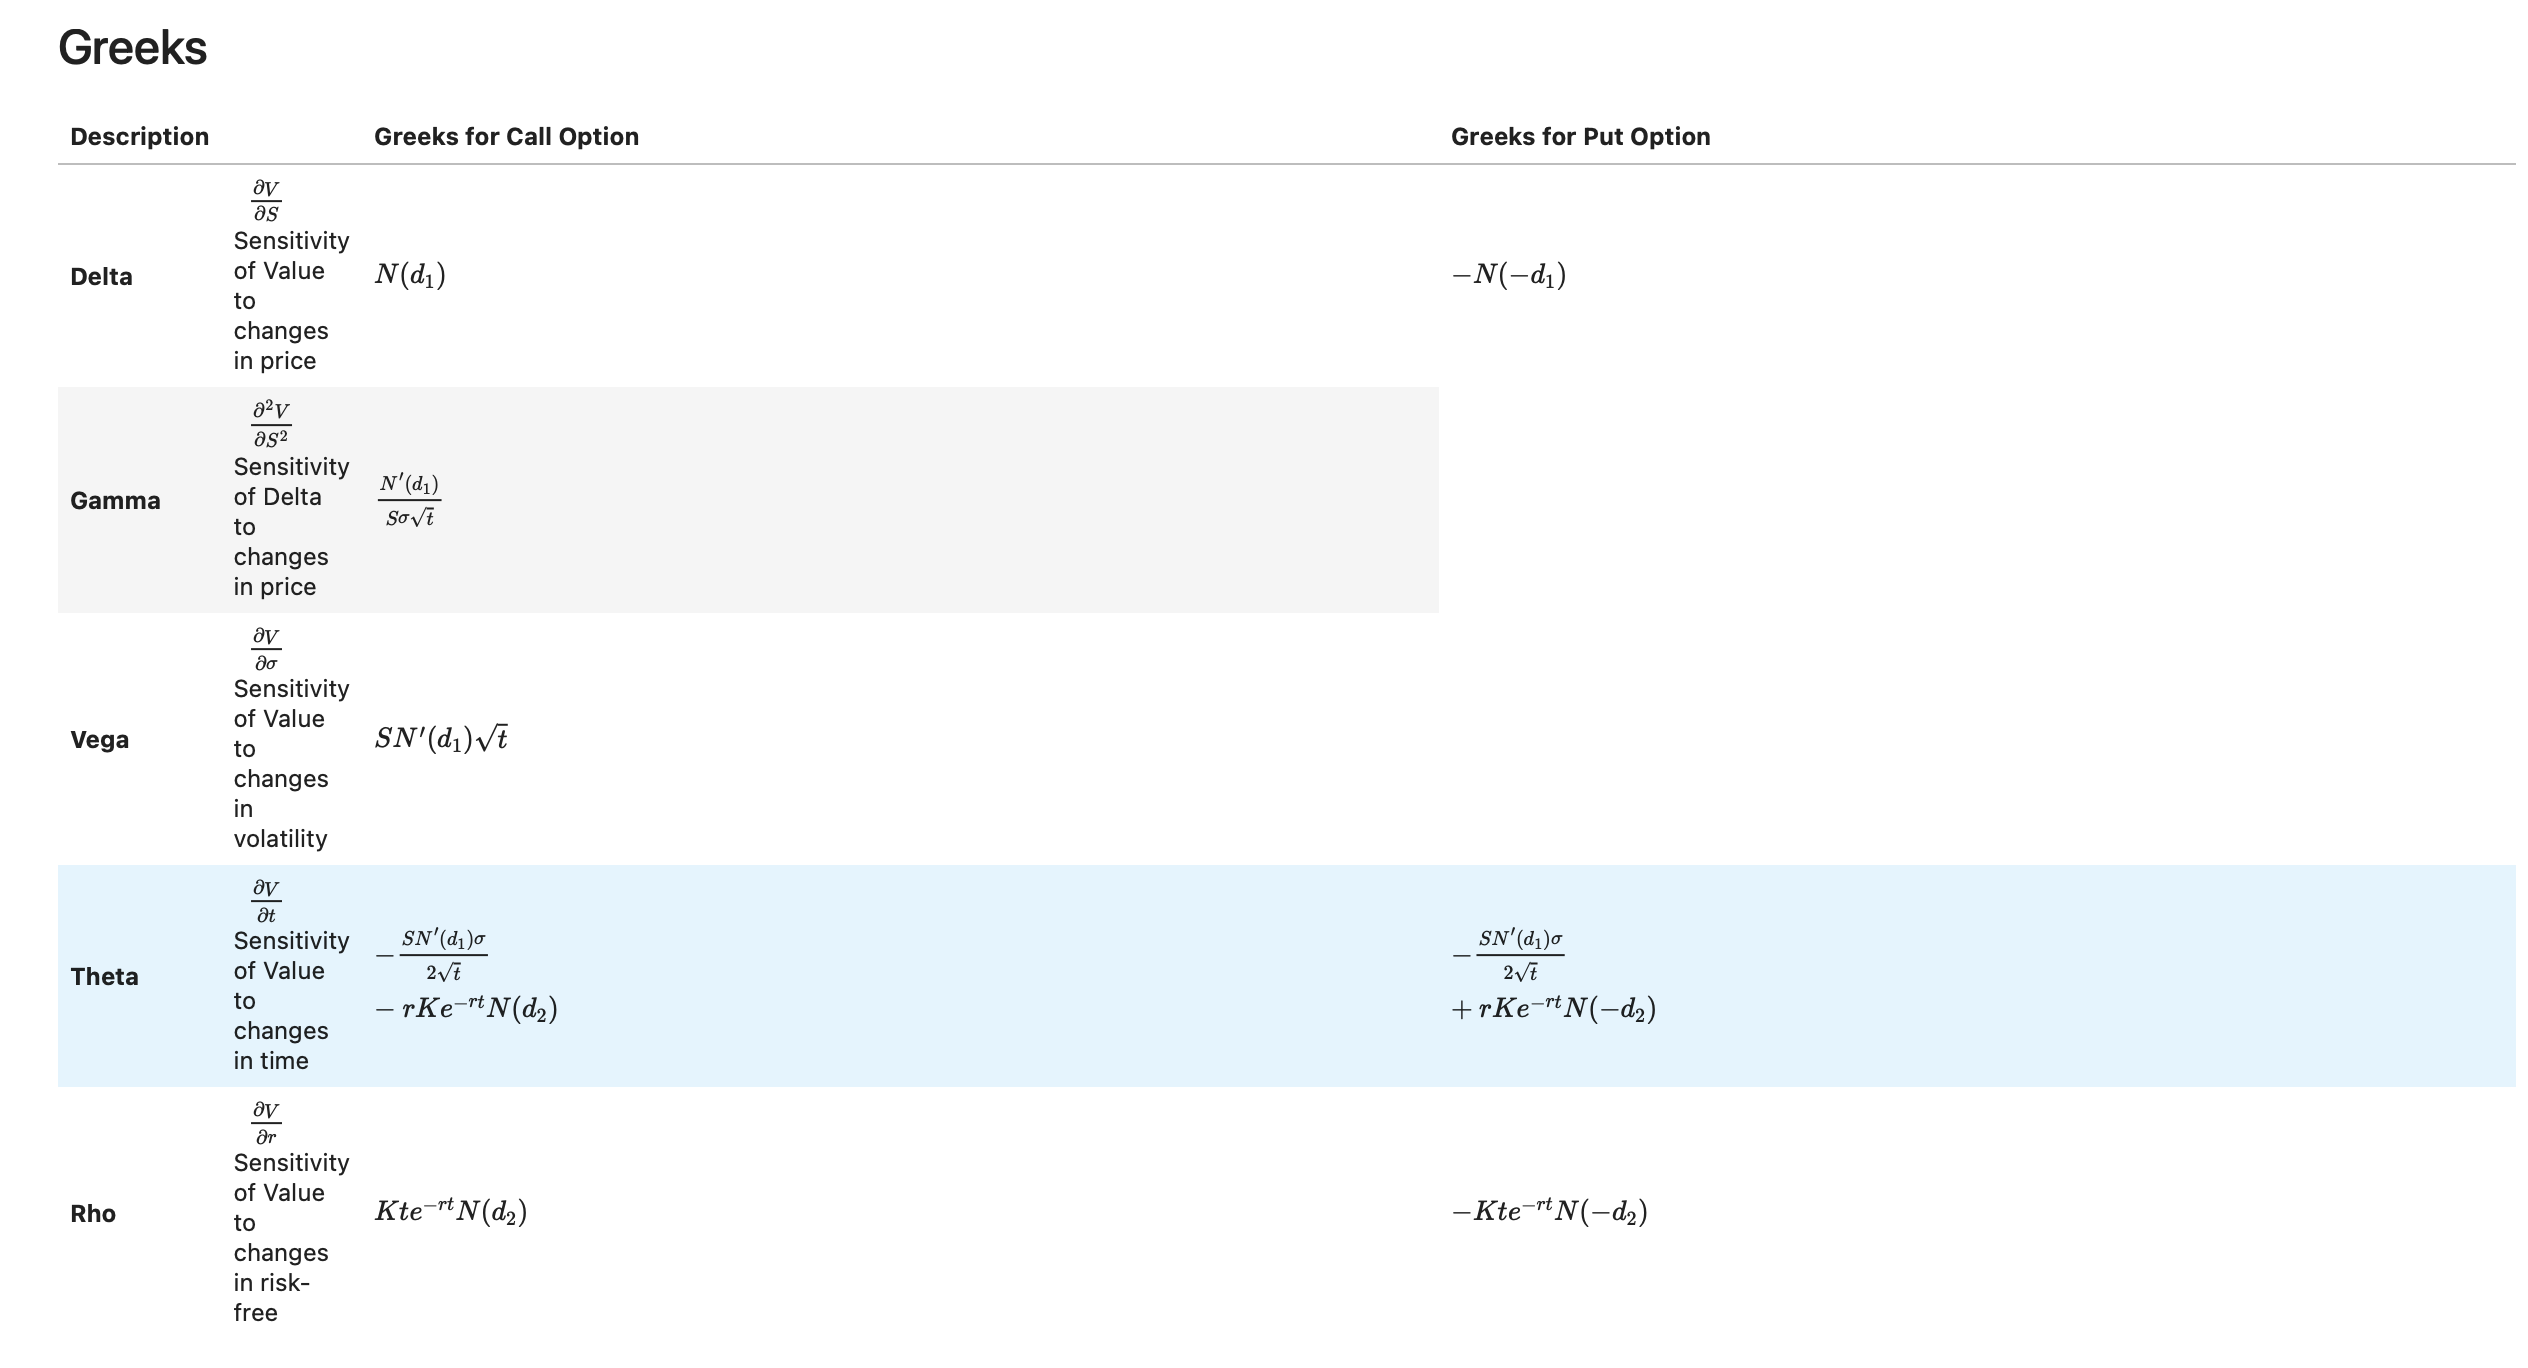

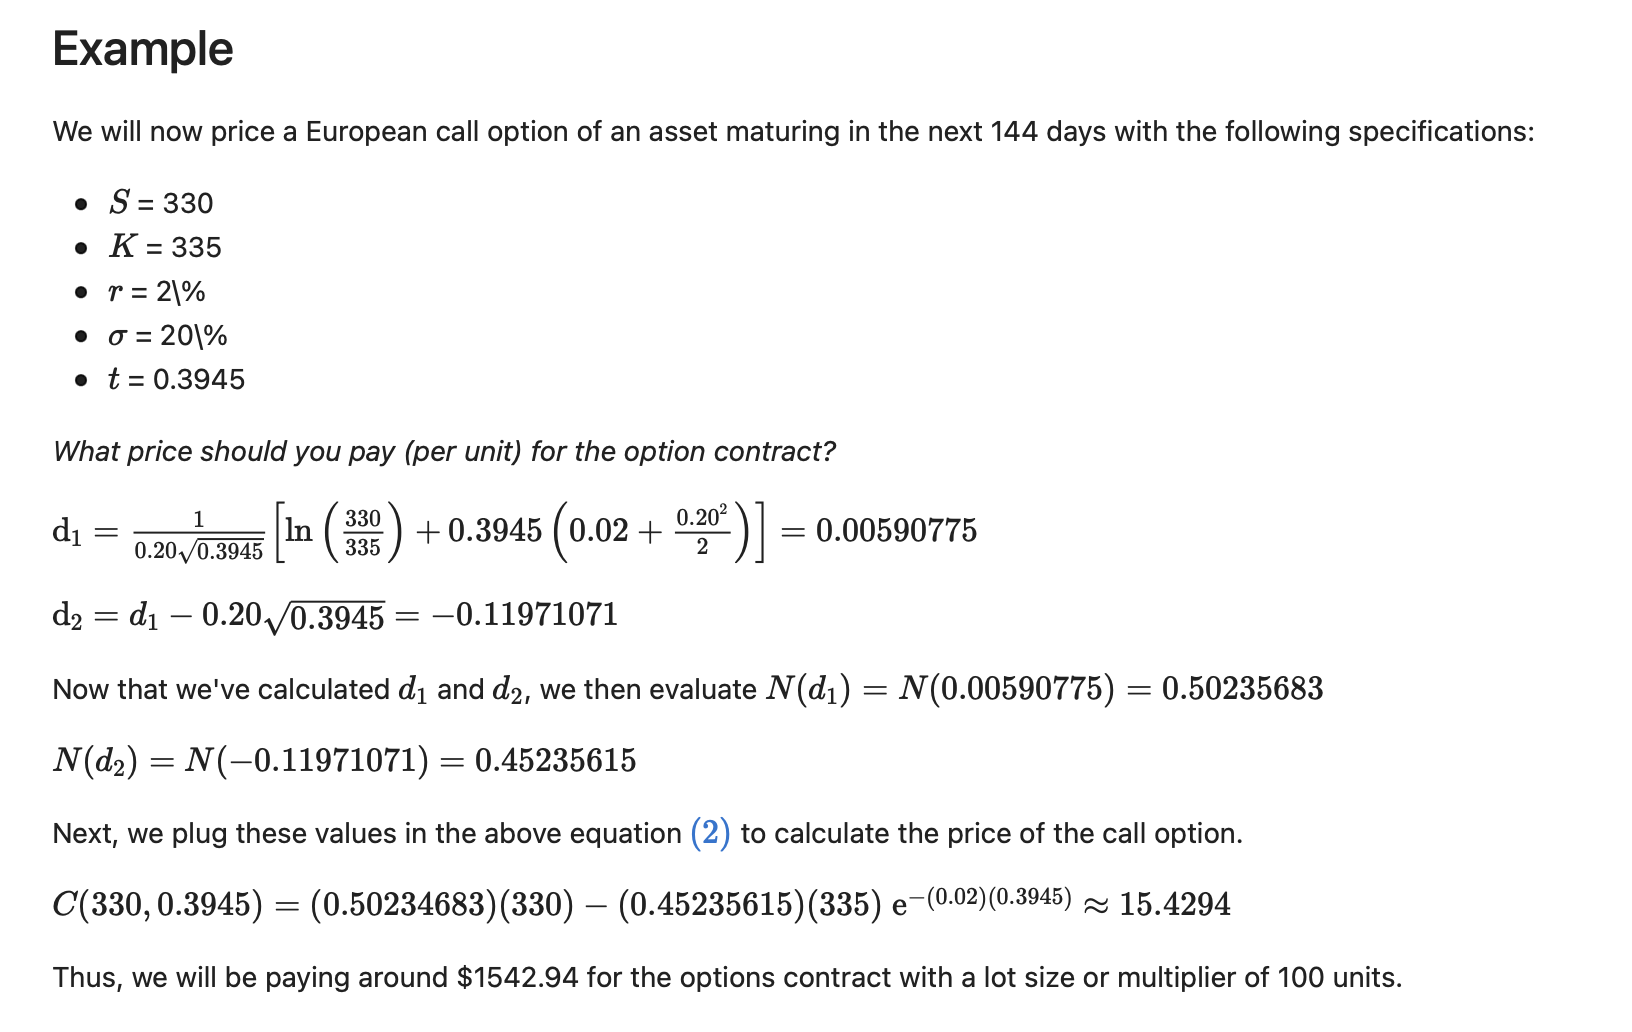

In [1]:
# Import required libraries
import pandas as pd
from numpy import *
from scipy.stats import norm

import matplotlib.pyplot as plt
from tabulate import tabulate # conda install tabulate

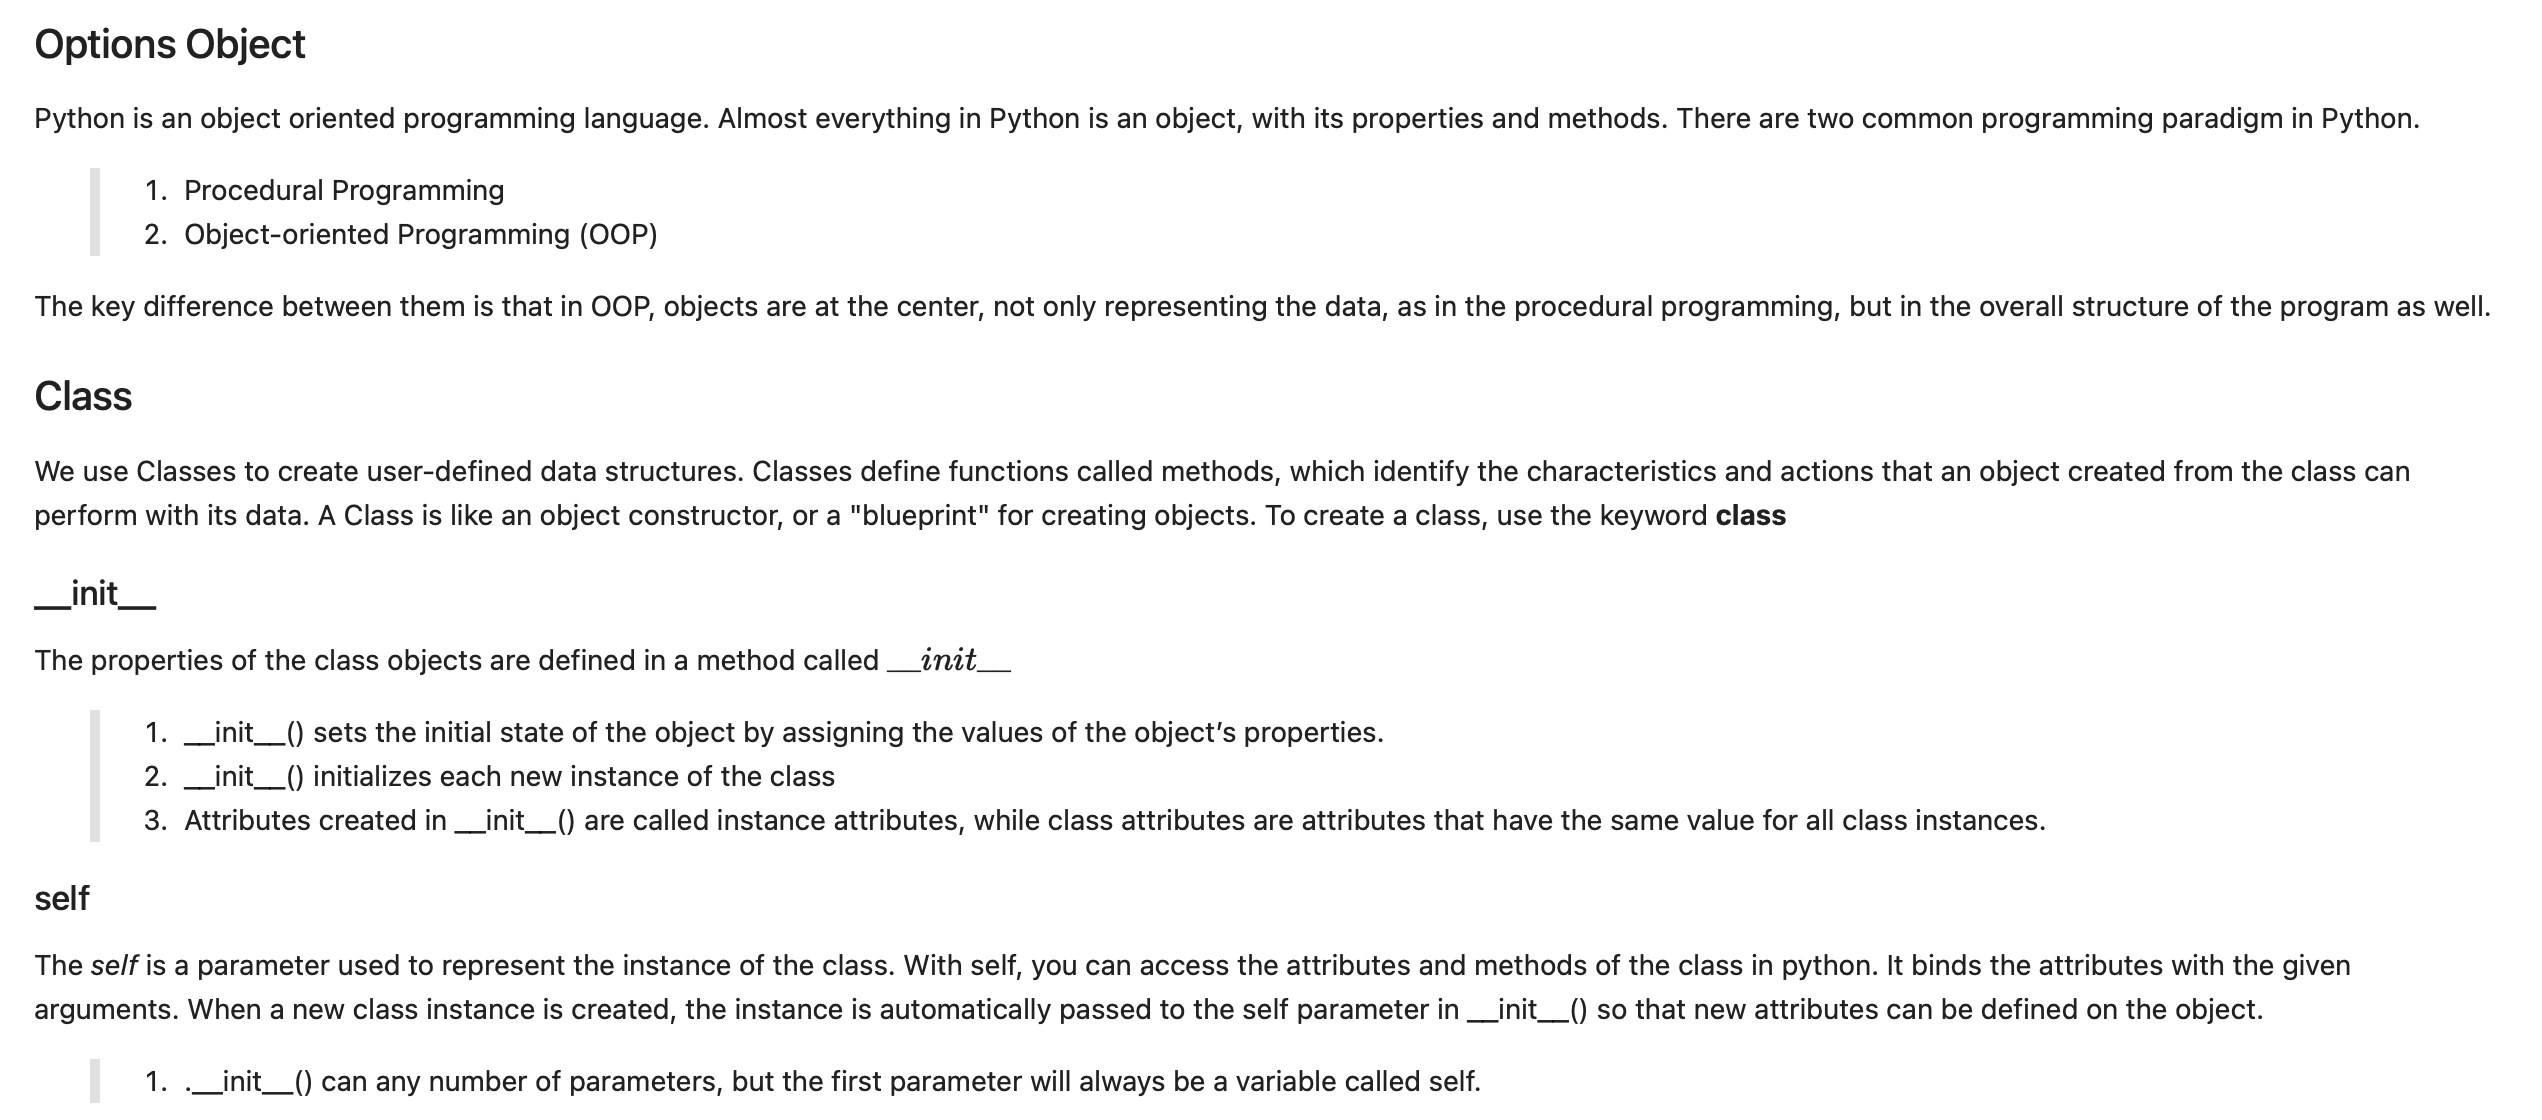

In [2]:
class BS:
    
    """
    This is a class for Options contract for pricing European options on stocks without dividends.
    
    Attributes: 
        spot          : int or float
        strike        : int or float 
        rate          : float
        dte           : int or float [days to expiration in number of years]
        volatility    : float
    """    
    
    def __init__(self, spot, strike, rate, dte, volatility):
        
        # Spot Price
        self.spot = spot
        
        # Option Strike
        self.strike = strike
        
        # Interest Rate
        self.rate = rate
        
        # Days To Expiration
        self.dte = dte
        
        # Volaitlity
        self.volatility = volatility
       
        # Utility 
        self._a_ = self.volatility * self.dte**0.5
        
        if self.strike == 0:
            raise ZeroDivisionError('The strike price cannot be zero') # raise an exception
        else:
            self._d1_ = (log(self.spot / self.strike) + \
                     (self.rate + (self.volatility**2) / 2) * self.dte) / self._a_
        
        self._d2_ = self._d1_ - self._a_
        
        self._b_ = e**-(self.rate * self.dte)
        
        
        # The __dict__ attribute
        '''
        Contains all the attributes defined for the object itself. It maps the attribute name to its value.
        '''
        for i in ['callPrice', 'putPrice', 'callDelta', 'putDelta', 'callTheta', 'putTheta', \
                  'callRho', 'putRho', 'vega', 'gamma']:
            self.__dict__[i] = None
        
        [self.callPrice, self.putPrice] = self._price()
        [self.callDelta, self.putDelta] = self._delta()
        [self.callTheta, self.putTheta] = self._theta()
        [self.callRho, self.putRho] = self._rho()
        self.vega = self._vega()
        self.gamma = self._gamma()
        
    
    # Option Price
    def _price(self):
        '''Returns the option price: [Call price, Put price]'''

        if self.volatility == 0 or self.dte == 0:
            call = maximum(0.0, self.spot - self.strike)
            put = maximum(0.0, self.strike - self.spot)
        else:
            call = self.spot * norm.cdf(self._d1_) - self.strike * e**(-self.rate * \
                                                                       self.dte) * norm.cdf(self._d2_)

            put = self.strike * e**(-self.rate * self.dte) * norm.cdf(-self._d2_) - \
                                                                        self.spot * norm.cdf(-self._d1_)
        return [call, put]

    # Option Delta
    def _delta(self):
        '''Returns the option delta: [Call delta, Put delta]'''

        if self.volatility == 0 or self.dte == 0:
            call = 1.0 if self.spot > self.strike else 0.0
            put = -1.0 if self.spot < self.strike else 0.0
        else:
            call = norm.cdf(self._d1_)
            put = -norm.cdf(-self._d1_)
        return [call, put]

    # Option Gamma
    def _gamma(self):
        '''Returns the option gamma'''
        return norm.pdf(self._d1_) / (self.spot * self._a_)

    # Option Vega
    def _vega(self):
        '''Returns the option vega'''
        if self.volatility == 0 or self.dte == 0:
            return 0.0
        else:
            return self.spot * norm.pdf(self._d1_) * self.dte**0.5 / 100

    # Option Theta
    def _theta(self):
        '''Returns the option theta: [Call theta, Put theta]'''
        call = -self.spot * norm.pdf(self._d1_) * self.volatility / (2 * self.dte**0.5) - self.rate * self.strike * self._b_ * norm.cdf(self._d2_)

        put = -self.spot * norm.pdf(self._d1_) * self.volatility / (2 * self.dte**0.5) + self.rate * self.strike * self._b_ * norm.cdf(-self._d2_)
        return [call / 365, put / 365]

    # Option Rho
    def _rho(self):
        '''Returns the option rho: [Call rho, Put rho]'''
        call = self.strike * self.dte * self._b_ * norm.cdf(self._d2_) / 100
        put = -self.strike * self.dte * self._b_ * norm.cdf(-self._d2_) / 100

        return [call, put]

In [3]:
# Initialize option
option = BS(100,100,0.05,1,0.2)

header = ['Option Price', 'Delta', 'Gamma', 'Theta', 'Vega', 'Rho']
table = [[option.callPrice, option.callDelta, option.gamma, option.callTheta, option.vega, option.callRho]]

print(tabulate(table,header))

  Option Price     Delta     Gamma       Theta     Vega       Rho
--------------  --------  --------  ----------  -------  --------
       10.4506  0.636831  0.018762  -0.0175727  0.37524  0.532325


# Visualize
Plot option values for range of spot prices over differece time

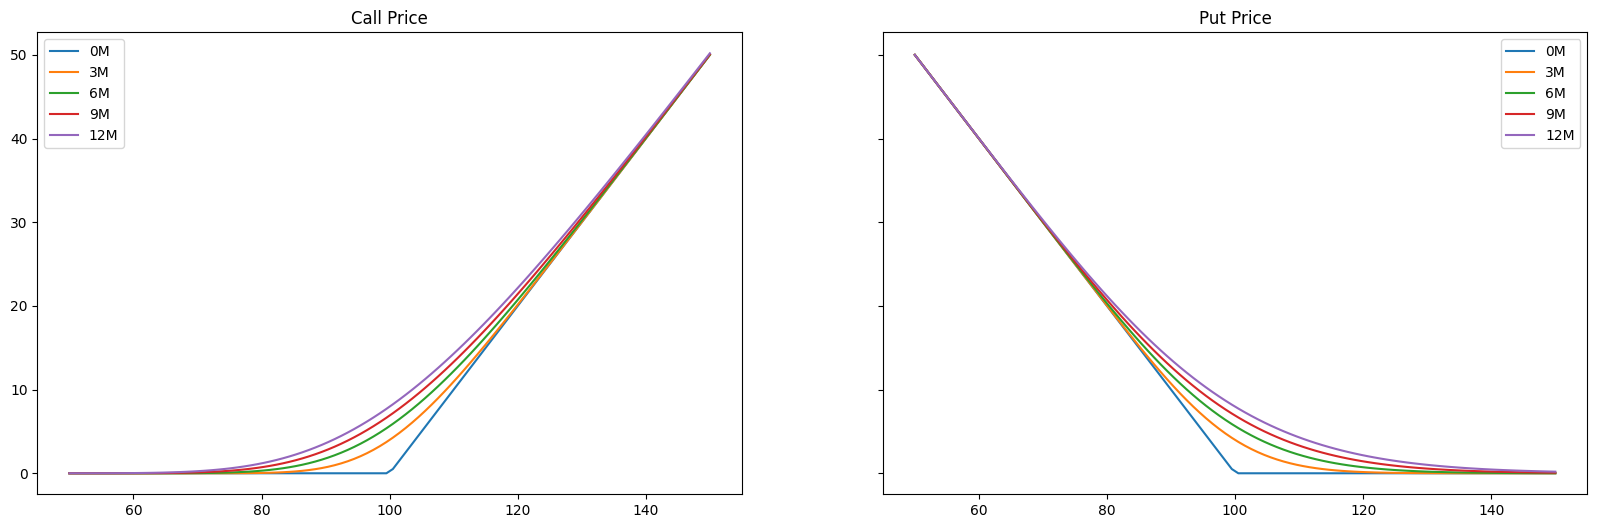

In [4]:
figure, axes = plt.subplots(1,2, figsize=(20,6), sharey=True)

x = linspace(50,150,100)
d = {'0M':1e-50, '3M': 0.25, '6M': 0.5, '9M': 0.75, '12M': 1.0}

for k,v in d.items():
    axes[0].plot(x, BS(x,100,0.0,v,0.2).callPrice, label=k)
    axes[1].plot(x, BS(x,100,0.0,v,0.2).putPrice, label=k)
    
# Set axis title
axes[0].set_title('Call Price'), axes[1].set_title('Put Price')

# Define legend
axes[0].legend(), axes[1].legend()

plt.show()

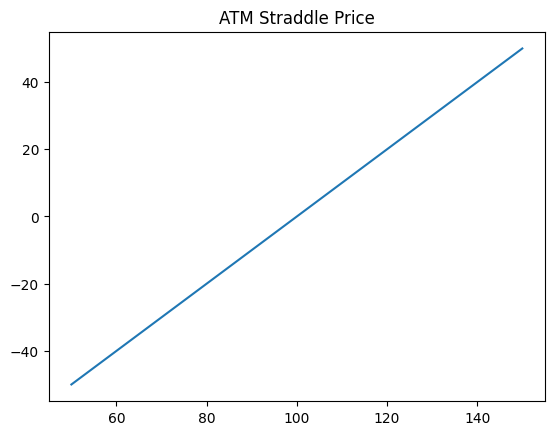

In [5]:
# Plot straddle price 
plt.plot(x, (BS(x,100,0.0,1,0.2).callPrice - BS(x,100,0.0,1,0.2).putPrice))
plt.title('ATM Straddle Price');

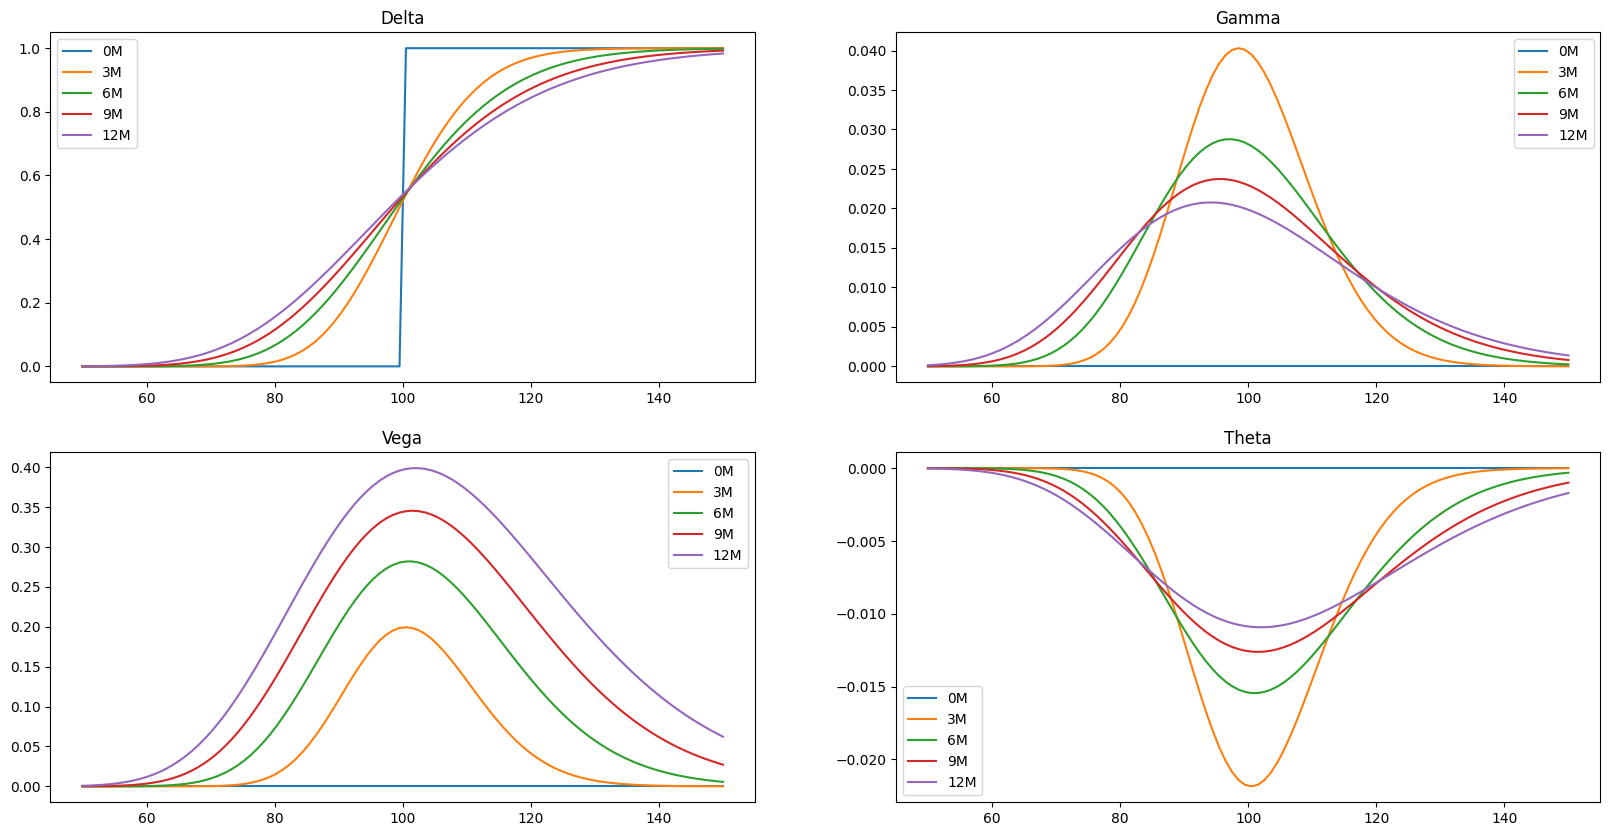

In [6]:
# Plot graph iteratively
fig, ax = plt.subplots(2,2, figsize=(20,10))

for k,v in d.items():
    ax[0,0].plot(x, BS(x,100,0.0,v,0.2).callDelta, label=k)
    ax[0,1].plot(x, BS(x,100,0.0,v,0.2).gamma, label=k)
    ax[1,0].plot(x, BS(x,100,0.0,v,0.2).vega, label=k)
    ax[1,1].plot(x, BS(x,100,0.0,v,0.2).callTheta, label=k)
    
# Set axis title
ax[0,0].set_title('Delta'), ax[0,1].set_title('Gamma'), ax[1,0].set_title('Vega'), ax[1,1].set_title('Theta')

# Define legend
ax[0,0].legend(), ax[0,1].legend(), ax[1,0].legend(), ax[1,1].legend()

plt.show()

# SPY Option
Let's now retrieve SPY option price from Yahoo Finance using yfinance library and manipulated the dataframe using the above Black Scholes option pricing model that we created.

In [7]:
import yfinance as yf

In [8]:
# Get SPY option chain
spy = yf.Ticker('SPY')
options = spy.option_chain('2023-03-31')

In [9]:
options[0]

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,SPY230331C00255000,2023-02-14 16:27:07+00:00,255.0,156.50,152.10,153.81,0.000000,0.000000,1.0,19,0.707767,True,REGULAR,USD
1,SPY230331C00260000,2023-02-17 18:13:00+00:00,260.0,145.71,147.45,148.52,23.880005,19.601088,2.0,1,0.686527,True,REGULAR,USD
2,SPY230331C00265000,2023-02-02 17:23:14+00:00,265.0,152.65,142.31,143.62,0.000000,0.000000,2.0,3,0.657962,True,REGULAR,USD
3,SPY230331C00275000,2022-12-15 16:49:30+00:00,275.0,116.06,124.89,126.30,0.000000,0.000000,12.0,19,0.000010,True,REGULAR,USD
4,SPY230331C00280000,2023-02-08 17:52:31+00:00,280.0,133.22,127.39,128.69,0.000000,0.000000,5.0,12,0.594242,True,REGULAR,USD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,SPY230331C00570000,2022-12-19 16:46:52+00:00,570.0,0.01,0.00,0.01,0.000000,0.000000,50.0,94,0.312507,False,REGULAR,USD
182,SPY230331C00575000,2022-12-29 20:57:07+00:00,575.0,0.01,0.00,0.01,0.000000,0.000000,1.0,164,0.320319,False,REGULAR,USD
183,SPY230331C00580000,2023-01-30 14:30:09+00:00,580.0,0.01,0.00,0.01,0.000000,0.000000,1.0,234,0.328132,False,REGULAR,USD
184,SPY230331C00585000,2023-02-01 19:51:30+00:00,585.0,0.01,0.00,0.01,0.000000,0.000000,1.0,308,0.335944,False,REGULAR,USD


In [10]:
# March 2023 335 SPY call option price
spot = 335
strike = 335
rate = 0.0
dte = 0.3945
vol = 0.2185
spy_opt = BS(spot,335,rate,dte,vol)
print(f'Option Price of SPY230317C00150000 with BS Model is {spy_opt.callPrice:0.4f}')

Option Price of SPY230317C00150000 with BS Model is 18.3269


In [11]:
# Filter calls for strike above 330
df = options.calls[options.calls['strike']>330]
df.reset_index(drop=True, inplace=True)

# Check the filtered output
df.iloc[:,:11].head()

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility
0,SPY230331C00335000,2023-02-17 16:27:32+00:00,335.0,71.00,72.96,74.13,-6.449997,-8.327950,20.0,1088,0.415167
1,SPY230331C00340000,2023-02-17 18:01:08+00:00,340.0,66.00,67.98,69.21,-4.000000,-5.714286,4.0,625,0.394659
2,SPY230331C00345000,2023-02-10 20:11:08+00:00,345.0,64.67,63.10,64.31,0.000000,0.000000,8.0,621,0.374762
3,SPY230331C00348000,2023-02-02 18:09:55+00:00,348.0,71.13,60.20,61.33,0.000000,0.000000,NaN,3,0.360724
4,SPY230331C00350000,2023-02-17 18:51:18+00:00,350.0,56.69,58.25,59.43,-6.060001,-9.657372,2.0,352,0.355231


In [12]:
# Dataframe manipulation with selected fields
df = pd.DataFrame({'Strike': df['strike'], 
                   'Price': df['lastPrice'], 
                   'ImpVol': df['impliedVolatility']})
# Check output
df.head(2)

,Strike,Price,ImpVol
0,335.0,71.0,0.415167
1,340.0,66.0,0.394659


In [13]:
# Derive greeks and assign to dataframe as columns
df['Delta'] = df['Gamma'] = df['Vega'] = df['Theta'] = 0.

for i in range(len(df)):
    
    df['Delta'].iloc[i] = BS(spot,df['Strike'].iloc[i],rate,dte,df['ImpVol'].iloc[i]).callDelta
    df['Gamma'].iloc[i] = BS(spot,df['Strike'].iloc[i],rate,dte,df['ImpVol'].iloc[i]).gamma
    df['Vega'].iloc[i] = BS(spot,df['Strike'].iloc[i],rate,dte,df['ImpVol'].iloc[i]).vega
    df['Theta'].iloc[i] = BS(spot,df['Strike'].iloc[i],rate,dte,df['ImpVol'].iloc[i]).callTheta

In [14]:
# Verify output
df.head()

,Strike,Price,ImpVol,Delta,Gamma,Vega,Theta
0,335.0,71.00,0.415167,0.551868,0.004528,0.832314,-0.119989
1,340.0,66.00,0.394659,0.525584,0.004794,0.837691,-0.114799
2,345.0,64.67,0.374762,0.497101,0.005059,0.839396,-0.109233
3,348.0,71.13,0.360724,0.478167,0.005248,0.838161,-0.104986
4,350.0,56.69,0.355231,0.466225,0.005318,0.836408,-0.103171


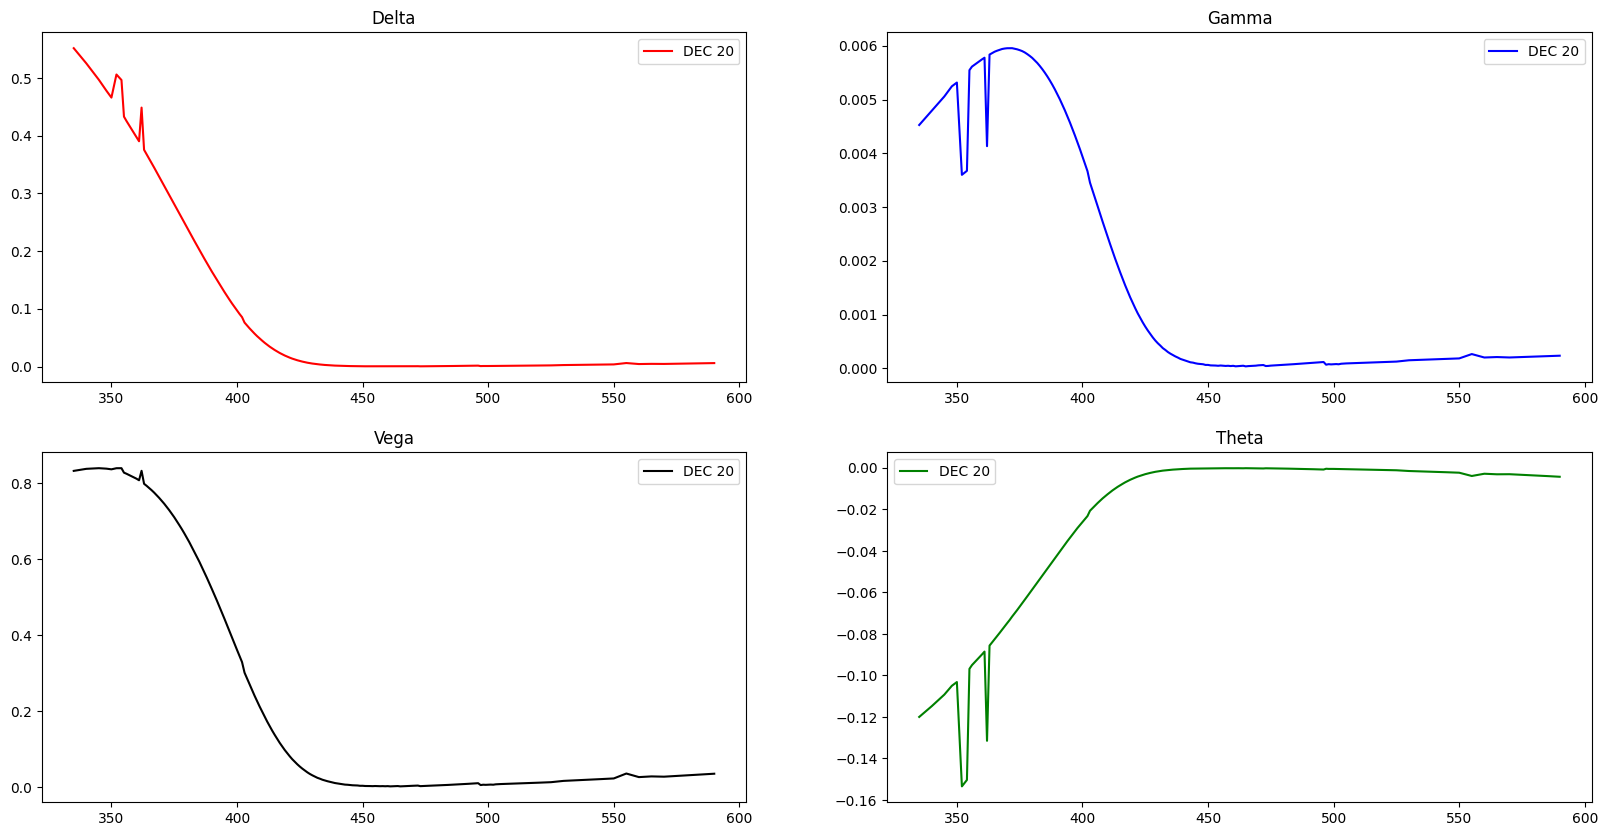

In [15]:
# Visualize the data
# Plot graph iteratively
fig, ax = plt.subplots(2,2, figsize=(20,10))

ax[0,0].plot(df['Strike'], df['Delta'], color='r', label='DEC 20')
ax[0,1].plot(df['Strike'], df['Gamma'], color='b', label='DEC 20')
ax[1,0].plot(df['Strike'], df['Vega'], color='k', label='DEC 20')
ax[1,1].plot(df['Strike'], df['Theta'], color='g', label='DEC 20')
    
# Set axis title
ax[0,0].set_title('Delta'), ax[0,1].set_title('Gamma'), ax[1,0].set_title('Vega'), ax[1,1].set_title('Theta')

# Define legend
ax[0,0].legend(), ax[0,1].legend(), ax[1,0].legend(), ax[1,1].legend()

plt.show()